References:
1. https://github.com/emalgorithm/directed-graph-neural-network/tree/main
2. https://emanuelerossi.co.uk/blog/2023/dirgnn/

# Import dependencies

In [ ]:
pip install pytorch_lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.0/823.0 kB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 81.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 61.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 85.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 960.9/960.9 kB 49.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink

In [ ]:
pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 51.3 MB/s eta 0:00:00


In [ ]:
import torch
from torch import nn, optim
import pytorch_lightning as pl
import torch.nn.functional as F
from torch.nn import ModuleList, Linear, ReLU, GRU
from torch_geometric.nn import (
    SAGEConv,
    GCNConv,
    GATConv,
    global_mean_pool,
    global_max_pool,
    global_add_pool,
)
from torch_geometric.data import Data, DataLoader, Dataset

import networkx as nx
import numpy as np
import os
import os.path as osp
import pandas as pd

import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Load PyG dataset

In [ ]:
FEATURE_DIMENSION = 9
TIMESTAMP_FEATURE_INDEX = 3
HEALTHY_NODE_LABEL = 0
ROOT_CAUSE_NODE_LABEL = 1
NUM_CLASSES = 2
NUM_NODES = 29

In [ ]:
class SimulatedDataset():
  def __init__(self, edge_idx_path, node_features_path, fault_label_path):
    self.edge_idx_path = edge_idx_path
    self.node_features_path = node_features_path
    self.fault_label_path = fault_label_path

    self.edge_index = self.get_edge_index(self.edge_idx_path)
    self.node_features, self.node_labels, self.time_stamps = self.get_node_features(self.node_features_path, self.fault_label_path)
    self.dataset_stats()


  def get_edge_index(self, path):
      edges = []
      with open(path, "r") as output:
        i = 0
        for line in output:
          edge = line.strip().split(',')
          edges.append([int(edge[0]), int(edge[1])])
      return torch.tensor(edges, dtype=torch.long).t().contiguous() # put edges into COO format

  def get_node_at_fault(self, path):
    node_at_fault, timestamp_of_fault = 0, 0
    with open(fault_label_path, "r") as output:
      ind = 0
      for line in output:
        node_at_fault, timestamp_of_fault = line.strip().split(',')
        ind += 1
      assert ind == 1 # there should only be one line in this file
    return int(node_at_fault), int(timestamp_of_fault)

  def get_node_features(self, node_features_path, fault_label_path):
    node_features, node_labels, time_stamps = [], [], []
    node_at_fault, timestamp_of_fault = self.get_node_at_fault(fault_label_path)
    with open(node_features_path, "r") as output:
      for line in output:
        items = line.strip().split(',')
        features = [list(map(int, items[i + 1 : i + FEATURE_DIMENSION + 1]))
                          for i in range(0, len(items), FEATURE_DIMENSION + 1)]
        time = max([node[TIMESTAMP_FEATURE_INDEX] for node in features]) # features[node_at_fault][TIMESTAMP_FEATURE_INDEX]
        features = torch.tensor(features)
        node_features.append(features)
        labels = [HEALTHY_NODE_LABEL] * features.shape[0]
        if time >= timestamp_of_fault:
          labels[node_at_fault] = ROOT_CAUSE_NODE_LABEL
        labels = torch.tensor(labels).reshape(features.shape[0])
        node_labels.append(labels)
        time_stamps.append(time)
    return node_features, node_labels, time_stamps

  def dataset_stats(self):
    self.feature_dimension = self.node_features[0].shape[1]
    self.num_nodes = self.node_features[0].shape[0]
    self.num_edges = self.edge_index.shape[1]
    self.num_graphs = len(self.node_features)
    self.num_classes = 2

  def report_dataset_stats(self):
    print(f'Number of nodes: {self.num_nodes}')
    print(f'Number of edges: {self.num_edges}')
    print(f'Number of graphs: {self.num_graphs}')
    print(f'Number of classes: {self.num_classes}')
    print(f'Feature dimension: {self.feature_dimension}')
    print(f'Node features: {self.node_features}')
    print(f'Node labels: {self.node_labels}')
    print(f'Edge index: {self.edge_index}')

## Helper functions

In [ ]:
def get_injection_time(file_name):
  return file_name.split('_')[-1].split('.')[0]

In [ ]:
def load_timestamp_instance(raw_data_path, subfolder, injection_time):
  instance = raw_data_path[subfolder][injection_time]
  pyg_dataset = SimulatedDataset(instance['edge_idx_path'], instance['node_features_path'], instance['fault_label_path'])

  data_list = []
  for i in range(pyg_dataset.num_graphs):
      x = pyg_dataset.node_features[i]
      y = pyg_dataset.node_labels[i]
      edge_index = pyg_dataset.edge_index
      timestamp = pyg_dataset.time_stamps[i]

      graph_data = Data(timestamp=timestamp, x=x, y=y, edge_index=edge_index)
      data_list.append(graph_data)

  return data_list

In [ ]:
def randomly_sample_instances(num_samples, raw_data_path, subfolder):
  injection_times = [get_injection_time(file_name) for file_name in os.listdir(os.path.join(auto_vehicle_folder, subfolder))]
  sampled_injection_times = np.random.choice(injection_times, num_samples, replace=False)
  instance_data_list = [load_timestamp_instance(raw_data_path, subfolder, injection_time) for injection_time in sampled_injection_times]
  return instance_data_list

In [ ]:
def compute_class_weights(instance, num_classes):
  class_0, class_1, total = 0, 0, 0
  for data in instance:
    total += 1
    has1, has0 = 0, 0
    for y in data.y:
      if y == 0:
        has0 += 1
      else:
        has1 += 1
    if has0 > 0:
      class_0 += 1
    if has1 > 0:
      class_1 += 1

  print(f'Total number of graphs: {total}, Presence of class 0: {class_0}, Presence of class 1: {class_1}')
  r = class_0/class_1
  class_0 = float(total/class_0)
  class_1 = float(total/class_1*r)
  class_weights = torch.tensor([class_0, class_1])

  return class_weights

```
# Compute class weights example:
Total number of graphs: 9367, Presence of class 0: 9367, Presence of class 1: 2368
tensor([ 1.0000, 15.6472])
```



## Load simulated autonomous vehicle data

In the `auto_vehicle_folder`, each `subfolder` specifies a type of fault and contains `instances` of simulating this fault at different `injection times`.

Load each instance to `raw_data_path[subfolder][injection_time]`.

In [ ]:
auto_vehicle_folder = '/content/drive/MyDrive/CS224 Project/autonomous_vehicle'

In [ ]:
subfolders = list(os.listdir(auto_vehicle_folder))
subfolders.remove('.DS_Store')
subfolders

['crash_camera_driver1',
 'crash_tracker',
 'drop_raw_camera1_publish',
 'drop_raw_camera1_receive',
 'mutate_raw_camera1_publish']

In [ ]:
raw_data_path = {}
for subfolder in subfolders:
  subfolder_path = os.path.join(auto_vehicle_folder, subfolder)
  raw_data_path[subfolder] = {}

  for file_name in os.listdir(subfolder_path):
    if 'inject' in file_name:
      injection_time = get_injection_time(file_name)
      node_features_path = os.path.join(subfolder_path, f'node_feature_inject_at_{injection_time}.csv')
      fault_label_path = os.path.join(subfolder_path, f'fault_label_inject_at_{injection_time}.csv')
      edge_idx_path = os.path.join(subfolder_path, 'edge_index.csv')
      raw_data_path[subfolder][injection_time] = {}
      raw_data_path[subfolder][injection_time]['node_features_path'] = node_features_path
      raw_data_path[subfolder][injection_time]['fault_label_path'] = fault_label_path
      raw_data_path[subfolder][injection_time]['edge_idx_path'] = edge_idx_path

In [ ]:
instance = raw_data_path[subfolders[0]]['1100']
instance

{'node_features_path': '/content/drive/MyDrive/CS224 Project/autonomous_vehicle/crash_camera_driver1/node_feature_inject_at_1100.csv',
 'fault_label_path': '/content/drive/MyDrive/CS224 Project/autonomous_vehicle/crash_camera_driver1/fault_label_inject_at_1100.csv',
 'edge_idx_path': '/content/drive/MyDrive/CS224 Project/autonomous_vehicle/crash_camera_driver1/edge_index.csv'}

In [ ]:
sum([len(raw_data_path[subfolders[i]]) for i in range(len(subfolders))])

200

# Models

In [ ]:
import torch
from torch import nn, optim
import pytorch_lightning as pl
import torch.nn.functional as F
from torch.nn import ModuleList, Linear
from torch_geometric.nn import (
    SAGEConv,
    GCNConv,
    GATConv,
)
from torch_geometric.nn.conv.gcn_conv import gcn_norm

In [ ]:
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree

## Directed graph conv layers

In [ ]:
class DirectedGCNConv(nn.ModuleList):
    def __init__(self, in_channels, out_channels):
      super(DirectedGCNConv, self).__init__()
      self.src_to_dst_conv = GCNConv(in_channels, out_channels, aggr='mean', improved=True)
      self.dst_to_src_conv = GCNConv(in_channels, out_channels, aggr='mean', improved=True)
      self.lin_self = Linear(in_channels, out_channels)

      # Learnable fusion weights
      self.fusion_weight = torch.nn.Parameter(torch.Tensor(3))
      torch.nn.init.uniform_(self.fusion_weight)

    def forward(self, x, edge_index):
      edge_index_out = edge_index
      edge_index_in = torch.stack([edge_index_out[1], edge_index_out[0]], dim=0)

      src_to_dst_out = self.src_to_dst_conv(x, edge_index_out)
      dst_to_src_out = self.dst_to_src_conv(x, edge_index_in)

      fusion_weight = F.softmax(self.fusion_weight, dim=0)
      out = fusion_weight[0] * self.lin_self(x) + fusion_weight[1] * src_to_dst_out + fusion_weight[2] * dst_to_src_out

      return out

In [ ]:
class DirectedSAGEConv(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DirectedSAGEConv, self).__init__()
        self.src_to_dst_conv = SAGEConv(in_channels, out_channels, aggr='mean')
        self.dst_to_src_conv = SAGEConv(in_channels, out_channels, aggr='mean')
        self.lin_self = Linear(in_channels, out_channels)

        # Learnable fusion weights
        self.fusion_weight = torch.nn.Parameter(torch.Tensor(3))
        torch.nn.init.uniform_(self.fusion_weight)

    def forward(self, x, edge_index):
        edge_index_out = edge_index
        edge_index_in = torch.stack([edge_index_out[1], edge_index_out[0]], dim=0)

        src_to_dst_out = self.src_to_dst_conv(x, edge_index_out)
        dst_to_src_out = self.dst_to_src_conv(x, edge_index_in)

        fusion_weight = F.softmax(self.fusion_weight, dim=0)
        out = fusion_weight[0] * self.lin_self(x) + fusion_weight[1] * src_to_dst_out + fusion_weight[2] * dst_to_src_out

        return out

In [ ]:
class DirectedGATConv(torch.nn.Module):
  def __init__(self, in_channels, out_channels, heads):
        super(DirectedGATConv, self).__init__()

        self.input_dim = in_channels
        self.output_dim = out_channels
        self.heads = heads

        self.src_to_dst_conv = GATConv(in_channels, out_channels, aggr='mean', heads=heads)
        self.dst_to_src_conv = GATConv(in_channels, out_channels, aggr='mean', heads=heads)

        # Learnable fusion weights
        self.fusion_weight = torch.nn.Parameter(torch.Tensor(2))
        torch.nn.init.uniform_(self.fusion_weight)

  def forward(self, x, edge_index):
      edge_index_out = edge_index
      edge_index_in = torch.stack([edge_index_out[1], edge_index_out[0]], dim=0)

      src_to_dst_out = self.src_to_dst_conv(x, edge_index_out)
      dst_to_src_out = self.dst_to_src_conv(x, edge_index_in)

      fusion_weight = F.softmax(self.fusion_weight, dim=0)
      out = src_to_dst_out + dst_to_src_out

      return out

In [ ]:
DirectedGCNConv(9, 18), DirectedSAGEConv(9, 18), DirectedGATConv(9, 18, 18)

(DirectedGCNConv(
   (0-1): 2 x GCNConv(9, 18)
   (2): Linear(in_features=9, out_features=18, bias=True)
 ),
 DirectedSAGEConv(
   (src_to_dst_conv): SAGEConv(9, 18, aggr=mean)
   (dst_to_src_conv): SAGEConv(9, 18, aggr=mean)
   (lin_self): Linear(in_features=9, out_features=18, bias=True)
 ),
 DirectedGATConv(
   (src_to_dst_conv): GATConv(9, 18, heads=18)
   (dst_to_src_conv): GATConv(9, 18, heads=18)
 ))

#Build models

## Spatial models

In [ ]:
class spatialGCN(torch.nn.Module):
    def __init__(self, input_features, hidden_dim, output_classes, directed):
        super(spatialGCN, self).__init__()
        if not directed:
          self.conv1 = GCNConv(input_features, hidden_dim)
          self.conv2 = GCNConv(hidden_dim, hidden_dim)
        if directed:
          self.conv1 = DirectedGCNConv(input_features, hidden_dim)
          self.conv2 = DirectedGCNConv(hidden_dim, hidden_dim)
        self.dropout = torch.nn.Dropout(p=0.5)
        self.classifier = Linear(hidden_dim, output_classes)

    def forward(self, data):
        x, edge_index = data.x.float(), data.edge_index

        x = self.conv1(x, edge_index)
        #x = F.sigmoid(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        #x = F.sigmoid(x)
        #x = self.dropout(x)


        # Apply the classifier to each node
        out = self.classifier(x)
        out = F.sigmoid(out)

        return out

In [ ]:
class spatialGraphSAGE(torch.nn.Module):
    def __init__(self, input_features, hidden_dim, output_classes, directed):
        super(spatialGraphSAGE, self).__init__()
        if not directed:
          self.conv1 = SAGEConv(input_features, hidden_dim)
          self.conv2 = SAGEConv(hidden_dim, hidden_dim)
        if directed:
          self.conv1 = DirectedSAGEConv(input_features, hidden_dim)
          self.conv2 = DirectedSAGEConv(hidden_dim, hidden_dim)
        self.dropout = torch.nn.Dropout(p=0.5)
        self.classifier = Linear(hidden_dim, output_classes)

    def forward(self, data):
        x, edge_index = data.x.float(), data.edge_index

        x = self.conv1(x, edge_index)
        #x = F.sigmoid(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        #x = F.sigmoid(x)
        #x = self.dropout(x)


        # Apply the classifier to each node
        out = self.classifier(x)
        out = F.sigmoid(out)

        return out

In [ ]:
class spatialGAT(torch.nn.Module):
    def __init__(self, input_features, hidden_dim, output_classes, directed):
        super(spatialGAT, self).__init__()
        if not directed:
          heads = input_features * 2
          self.conv1 = GATConv(input_features, hidden_dim, heads = heads)
          self.conv2 = GATConv(hidden_dim*heads, hidden_dim, heads = 1)
        if directed:
          heads = input_features * 2
          self.conv1 = DirectedGATConv(input_features, hidden_dim, heads = heads)
          self.conv2 = DirectedGATConv(hidden_dim*heads, hidden_dim, heads = 1)
        self.dropout = torch.nn.Dropout(p=0.5)
        self.classifier = Linear(hidden_dim, output_classes)

    def forward(self, data):
        x, edge_index = data.x.float(), data.edge_index

        x = self.conv1(x, edge_index)
        #x = F.sigmoid(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        #x = F.sigmoid(x)
        #x = self.dropout(x)


        # Apply the classifier to each node
        out = self.classifier(x)
        out = F.sigmoid(out)

        return out


## Spatiotemporal models

To learn temporal information from the simulated dataset, we combined RNN models with GNN by implementing LSTM and GRU for each node.

In [ ]:
from torch.nn import Sequential, Linear, ReLU, GRU, ELU
from torch_geometric.nn import global_mean_pool

### Discrete timestamps

In [ ]:
class GRUGCN(torch.nn.Module):
    def __init__(self, input_features, hidden_dim, num_classes, directed):
        super(GRUGCN, self).__init__()
        if not directed:
          self.conv1 = GCNConv(input_features, hidden_dim)
          self.conv2 = GCNConv(hidden_dim, hidden_dim)
        if directed:
          self.conv1 = DirectedGCNConv(input_features, hidden_dim)
          self.conv2 = DirectedGCNConv(hidden_dim, hidden_dim)
        self.gru = GRU(hidden_dim, hidden_dim)
        self.dropout = torch.nn.Dropout(p=0.5)
        self.classifier = Linear(hidden_dim, num_classes)

    def forward(self, x, edge_index, h):
        # Apply GCN layers
        x = self.conv1(x, edge_index)
        x = F.sigmoid(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = F.sigmoid(x)

        # Prepare x for GRU (need [batch, seq_len, features] format)
        #x = x.reshape(29, 9)
        x = x.view(1, 29, x.size(1))

        # Process temporal features
        if h is None:
            out, h = self.gru(x)
        else:
            out, h = self.gru(x, h)


        # Apply the classifier to each node
        out = out.view(NUM_NODES, hidden_dim)  # Flatten [batch, num_nodes, features] for classification
        out = self.classifier(out)
        out = F.sigmoid(out)

        return out, h

In [ ]:
class GRUSAGE(torch.nn.Module):
    def __init__(self, input_features, hidden_dim, num_classes, directed):
        super(GRUSAGE, self).__init__()
        if not directed:
          self.conv1 = SAGEConv(input_features, hidden_dim)
          self.conv2 = SAGEConv(hidden_dim, hidden_dim)
        if directed:
          self.conv1 = DirectedSAGEConv(input_features, hidden_dim)
          self.conv2 = DirectedSAGEConv(hidden_dim, hidden_dim)
        self.gru = GRU(hidden_dim, hidden_dim)
        self.dropout = torch.nn.Dropout(p=0.5)
        self.classifier = Linear(hidden_dim, num_classes)

    def forward(self, x, edge_index, h):
        # Apply SAGConv layers
        x = self.conv1(x, edge_index)
        x = F.sigmoid(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = F.sigmoid(x)

        # Prepare x for GRU (need [batch, seq_len, features] format)
        x = x.view(1, 29, x.size(1))

        # Process temporal features
        if h is None:
            out, h = self.gru(x)
        else:
            out, h = self.gru(x, h)


        # Apply the classifier to each node
        out = out.view(NUM_NODES, hidden_dim)  # Flatten [batch, num_nodes, features] for classification
        out = self.classifier(out)
        out = F.sigmoid(out)

        return out, h

In [ ]:
class GRUGAT(torch.nn.Module):
    def __init__(self, input_features, hidden_dim, num_classes, directed):
        super(GRUGAT, self).__init__()
        if not directed:
          heads = input_features * 2
          self.conv1 = GATConv(input_features, hidden_dim, heads = heads)
          self.conv2 = GATConv(hidden_dim*heads, hidden_dim, heads = 1)
        if directed:
          heads = input_features * 2
          self.conv1 = DirectedGATConv(input_features, hidden_dim, heads = heads)
          self.conv2 = DirectedGATConv(hidden_dim*heads, hidden_dim, heads = 1)
        self.gru = GRU(hidden_dim, hidden_dim)
        self.dropout = torch.nn.Dropout(p=0.5)
        self.classifier = Linear(hidden_dim, num_classes)

    def forward(self, x, edge_index, h):
        # Apply SAGConv layers
        x = self.conv1(x, edge_index)
        x = F.sigmoid(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = F.sigmoid(x)

        # Prepare x for GRU (need [batch, seq_len, features] format)
        x = x.view(1, 29, x.size(1))

        # Process temporal features
        if h is None:
            out, h = self.gru(x)
        else:
            out, h = self.gru(x, h)


        # Apply the classifier to each node
        out = out.view(NUM_NODES, hidden_dim)  # Flatten [batch, num_nodes, features] for classification
        out = self.classifier(out)
        out = F.sigmoid(out)

        return out, h

#Train and evaluate models

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import seaborn as sns
import copy

In [ ]:
def spatial_train(model, loader, class_weights, num_epoch, verbose, lr=0.001, weight_decay=5e-4):
  optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)  # Define optimizer once

  model.train()
  rec_improve = None
  best_rec = None
  best_model = None

  for epoch in range(num_epoch):
      preds = []
      targets = []
      bp_counts = 0

      if class_weights is True:
          loss_function = torch.nn.CrossEntropyLoss(weight=compute_class_weights(loader, output_classes))
      else:
          loss_function = torch.nn.CrossEntropyLoss()

      for data in loader:  # Assuming data_loader provides data for each time step
        i = 0
        num_graphs = len(instance)
        optimizer.zero_grad()
        i += 1

        out = model(data)

        # Calculate accuracy
        _, pred = torch.max(out, 1)

        preds.append(out)
        targets.append(data.y.view(-1))

        if (pred == data.y.view(-1)).sum().item()/data.y.size(0) < 1:
          loss = loss_function(out, data.y.view(-1))
          loss.backward()
          optimizer.step()
          bp_counts += 1

      t_l = loss_function(torch.cat(preds), torch.cat(targets))
      acc = accuracy_score(torch.cat(targets), torch.cat(preds).argmax(dim=1))
      f1 = f1_score(torch.cat(targets), torch.cat(preds).argmax(dim=1), average='macro')
      rec = recall_score(torch.cat(targets), torch.cat(preds).argmax(dim=1), average='macro', zero_division=np.nan)

      if verbose:
        print(f'Epoch {epoch+1}, Total weighted loss: {t_l:.5f}, Macro recall: {rec:.5f}, Total accuracy: {acc:.5f}, Macro F1-score: {f1:.5f}. Loss backpropagated {bp_counts} times.')

      if best_rec == None:
        best_rec = rec
        best_model = copy.deepcopy(model)
      rec_improve = float(rec/best_rec)
      best_rec = max(rec, best_rec)
      if rec_improve > 1.0:
        best_model = copy.deepcopy(model)
      if rec_improve < (0.95+0.01*(epoch-1)):
          print('Recall score not improving. Early stopping triggered.')
          model = best_model
          return best_model
  model = best_model
  return best_model

In [ ]:
def spatial_evaluate(model, model_name, loader, plt_confusion_matrix = True):
    model.eval()
    preds = []
    targets = []

    with torch.no_grad():  # Disable gradient tracking
      for data in loader:
          data.x = data.x.float()  # Ensure features are in float format
          out = model(data)  # Forward pass
          pred = out.argmax(dim=1)  # Get predictions
          preds.append(pred.cpu())  # Store predictions on CPU
          targets.append(data.y.cpu())  # Store true labels on CPU

    preds = torch.cat(preds)
    targets = torch.cat(targets)

    report = classification_report(targets, preds, digits=4, zero_division=0)
    print(f'Model: {model_name}')
    print('====================')
    print(report)

    if plt_confusion_matrix:
      generate_cm(targets, preds, model_name)

In [ ]:
def spatiotemporal_train(model, loader, class_weights, num_epoch, verbose, lr=0.001, weight_decay=5e-4):
  optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)  # Define optimizer once

  model.train()
  rec_improve = None
  best_rec = None
  best_model = None

  for epoch in range(num_epoch):
      preds = []
      targets = []
      bp_counts = 0
      for instance in loader:
        h = None
        i = 0
        if class_weights is True:
          loss_function = torch.nn.CrossEntropyLoss(weight=compute_class_weights(instance, output_classes))
        else:
          loss_function = torch.nn.CrossEntropyLoss()

        for data in instance:  # Assuming data_loader provides data for each time step
          optimizer.zero_grad()
          i += 1

          if h is None:
            h = torch.zeros(1, data.x.size(0), model.gru.hidden_size, device=data.x.device)
            out, h = model(data.x.float(), data.edge_index, h)  # Detach h to prevent backprop through the entire history
          else:
            out, h = model(data.x.float(), data.edge_index, h.detach())   # Detach h to prevent backprop through the entire history

          # Calculate accuracy
          _, pred = torch.max(out, 1)

          preds.append(out)
          targets.append(data.y.view(-1))

          if (pred == data.y.view(-1)).sum().item()/data.y.size(0) < 1:
            loss = loss_function(out, data.y.view(-1))
            loss.backward()
            optimizer.step()
            bp_counts += 1 #counts how many times the model backpropagates

      t_l = loss_function(torch.cat(preds), torch.cat(targets))
      acc = accuracy_score(torch.cat(targets), torch.cat(preds).argmax(dim=1))
      f1 = f1_score(torch.cat(targets), torch.cat(preds).argmax(dim=1), average='macro')
      rec = recall_score(torch.cat(targets), torch.cat(preds).argmax(dim=1), average='macro', zero_division=np.nan)

      if verbose:
        print(f'Epoch {epoch+1}, Total weighted loss: {t_l:.5f}, Macro recall: {rec:.5f}, Total accuracy: {acc:.5f}, Macro F1-score: {f1:.5f}. Loss backpropagated {bp_counts} times.')

      if best_rec == None:
        best_rec = rec
        best_model = copy.deepcopy(model)
      rec_improve = float(rec/best_rec)
      best_rec = max(rec, best_rec)
      if rec_improve > 1.0:
        best_model = copy.deepcopy(model)
      if rec_improve < (0.95+0.01*(epoch-1)):
          print('Recall score not improving. Early stopping triggered.')
          model = best_model
          return best_model
  model = best_model
  return best_model

In [ ]:
def spatiotemporal_evaluate(model, model_name, loader, plt_confusion_matrix = True):
    model.eval()
    preds = []
    targets = []
    total = 0
    correct = 0
    with torch.no_grad():
        h = None
        for instance in loader:
            for data in instance:
                  data.x = data.x.float()
                  out, h = model(data.x, data.edge_index, h)
                  _, pred = torch.max(out, 1)
                  preds.append(pred.cpu())
                  targets.append(data.y.cpu())
                  total += data.y.size(0)
                  correct += (pred == data.y.view(-1)).sum().item()

    accuracy = 100 * correct / total
    preds = torch.cat(preds)
    targets = torch.cat(targets)

    report = classification_report(targets, preds, digits=4, zero_division=0)
    print(f'Model: {model_name}')
    print('====================')
    print(report)

    if plt_confusion_matrix:
      generate_cm(targets, preds, model_name)

In [ ]:
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib.colors import Colormap

colors = {
    'Undirected_GCN': 'Oranges',
    'Undirected_GraphSAGE':'Greens',
    'Undirected_GAT': 'Greys',
    'Directed_GCN': 'Reds',
    'Directed_GraphSAGE':'Blues',
    'Directed_GAT': 'Purples',
    'Undirected_GRUGCN': 'YlOrBr',
    'Undirected_GRUSAGE': 'YlGn',
    'Undirected_GRUGAT': 'bone_r',
    'Directed_GRUGCN': 'RdPu',
    'Directed_GRUSAGE': 'GnBu',
    'Directed_GRUGAT': 'pink_r',
}

In [ ]:
def generate_cm(y_true, y_pred, model_name = None, colors = colors):
  cm = confusion_matrix(y_true, y_pred)
  cm_percentage = cm.astype('float') / cm.sum(axis=1, keepdims=True)  # Normalize rows

  labels = np.array([[f"{percent*100.0000:.2f}%\n({count})" for count, percent in zip(row_counts, row_percents)]
                      for row_counts, row_percents in zip(cm, cm_percentage)])

  sns.heatmap(cm_percentage, annot=labels, fmt='', cmap=colors[model_name], xticklabels=['Normal', 'Anamoly'], yticklabels=['Normal', 'Anamoly'])
  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')
  if model_name != None:
    plt.title(f'{model_name} Confusion Matrix')
  plt.show()
  plt.close()

In [ ]:
def spatial_data_loader(instance_data_list, batch_size=1, shuffle=True):
  instance_data_list_flattened = [item for sublist in instance_data_list for item in sublist]
  return DataLoader(instance_data_list_flattened, batch_size=batch_size, shuffle=shuffle)

In [ ]:
def spatiotemporal_data_loader(instance_data_list, batch_size=1, shuffle=True):
  return DataLoader(instance_data_list, batch_size=batch_size, shuffle=shuffle)

# Compare models

**Precision**: Measures the accuracy of positive predictions.

**Recall**: Measures the model’s ability to find all relevant instances of each class.

**F1-Score**: The harmonic mean of precision and recall, which balances the two metrics.

**Support**: The number of true instances for each class.

**Macro Average**: Takes the average of each metric without considering the class support, providing an unweighted view.

**Weighted Average**: Takes the average of each metric, weighted by the number of instances in each class.

## Experiment configurations

In [ ]:
input_dim = FEATURE_DIMENSION
hidden_dim = input_dim * 2
output_classes = NUM_CLASSES
modes = ['spatial', 'spatiotemporal']
settings = ['Undirected', 'Directed']
model_names = ['DirectedGCN', 'DirectedGraphSAGE', 'DirectedGAT', 'GRUGCN', 'GRUSAGE']
experiment_session = 'experiment2'

In [ ]:
MODELS = {}
MODELS['spatial'] = {
    'Undirected_GCN': spatialGCN(input_dim, hidden_dim, output_classes, directed=False),
    'Undirected_GraphSAGE':spatialGraphSAGE(input_dim, hidden_dim, output_classes, directed=False),
    'Undirected_GAT': spatialGAT(input_dim, hidden_dim, output_classes, directed=False),
    'Directed_GCN': spatialGCN(input_dim, hidden_dim, output_classes, directed=True),
    'Directed_GraphSAGE':spatialGraphSAGE(input_dim, hidden_dim, output_classes, directed=True),
    'Directed_GAT': spatialGAT(input_dim, hidden_dim, output_classes, directed=True),
    'load': spatial_data_loader,
    'train': spatial_train,
    'evaluate': spatial_evaluate,
    }
MODELS['spatiotemporal'] = {
    'Undirected_GRUGCN': GRUGCN(input_dim, hidden_dim, output_classes, directed=False),
    'Undirected_GRUSAGE': GRUSAGE(input_dim, hidden_dim, output_classes, directed=False),
    'Undirected_GRUGAT': GRUGAT(input_dim, hidden_dim, output_classes, directed=False),
    'Directed_GRUGCN': GRUGCN(input_dim, hidden_dim, output_classes, directed=True),
    'Directed_GRUSAGE': GRUSAGE(input_dim, hidden_dim, output_classes, directed=True),
    'Directed_GRUGAT': GRUGAT(input_dim, hidden_dim, output_classes, directed=True),
    'load': spatiotemporal_data_loader,
    'train': spatiotemporal_train,
    'evaluate': spatiotemporal_evaluate,
    }

In [ ]:
for mode in modes:
  for model_name in MODELS[mode].keys():
    print(model_name)
    print(MODELS[mode][model_name])

Undirected_GCN
spatialGCN(
  (conv1): GCNConv(9, 18)
  (conv2): GCNConv(18, 18)
  (dropout): Dropout(p=0.5, inplace=False)
  (classifier): Linear(in_features=18, out_features=2, bias=True)
)
Undirected_GraphSAGE
spatialGraphSAGE(
  (conv1): SAGEConv(9, 18, aggr=mean)
  (conv2): SAGEConv(18, 18, aggr=mean)
  (dropout): Dropout(p=0.5, inplace=False)
  (classifier): Linear(in_features=18, out_features=2, bias=True)
)
Undirected_GAT
spatialGAT(
  (conv1): GATConv(9, 18, heads=18)
  (conv2): GATConv(324, 18, heads=1)
  (dropout): Dropout(p=0.5, inplace=False)
  (classifier): Linear(in_features=18, out_features=2, bias=True)
)
Directed_GCN
spatialGCN(
  (conv1): DirectedGCNConv(
    (0-1): 2 x GCNConv(9, 18)
    (2): Linear(in_features=9, out_features=18, bias=True)
  )
  (conv2): DirectedGCNConv(
    (0-1): 2 x GCNConv(18, 18)
    (2): Linear(in_features=18, out_features=18, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (classifier): Linear(in_features=18, out_features=2, bias

### Helper functions

In [ ]:
def generate_comparative_cases(num_samples, instance_types, raw_data_path):
  compare_cases_list = []
  for i in range(len(instance_types)):
    compare_cases = {}
    training_instance = instance_types[i]
    training_instance_data_list = randomly_sample_instances(num_samples*2, raw_data_path, training_instance)
    train_instance_data_list, test_data_list1 = training_instance_data_list[:num_samples], training_instance_data_list[num_samples:]
    compare_cases[f'Training data list on a single error type: {training_instance}, {num_samples} samples'] = train_instance_data_list
    compare_cases[f'How does the model perform on unseen data, of the same error type?: {training_instance}, {num_samples} samples'] = test_data_list1
    for j in range(len(instance_types)):
      if j != i:
        test_data_list = randomly_sample_instances(num_samples, raw_data_path, instance_types[j])
        compare_cases[f'How does the model perform on unseen data, of a different error type?: {instance_types[j]}, {num_samples} samples'] = test_data_list
    compare_cases_list.append(compare_cases)
  return compare_cases_list

In [ ]:
def apply_model(setting, model_name, input_features, hidden_dim, output_classes):
    model = MODELS[setting][model_name](input_features, hidden_dim, output_classes)
    return model

In [ ]:
def save_model(model, path, file_name, optimizer = None):
  torch.save(model.state_dict(), os.path.join(path, f'{file_name}_weights.pt'))
  if optimizer is not None:
    torch.save(optimizer.state_dict(), os.path.join(path, f'{file_name}_optimizer.pt'))
  torch.save(model, os.path.join(path, f'{file_name}_full.pt'))

### Load data

In [ ]:
experiment_datalists = generate_comparative_cases(1, subfolders[:2], raw_data_path)

In [ ]:
import pickle
with open('experiment2_datalists.pkl', 'wb') as file:
    pickle.dump(experiment_datalists, file)

In [ ]:
for experiment in experiment_datalists:
  print(experiment.keys())

dict_keys(['Training data list on a single error type: crash_camera_driver1, 1 samples', 'How does the model perform on unseen data, of the same error type?: crash_camera_driver1, 1 samples', 'How does the model perform on unseen data, of a different error type?: crash_tracker, 1 samples'])
dict_keys(['Training data list on a single error type: crash_tracker, 1 samples', 'How does the model perform on unseen data, of the same error type?: crash_tracker, 1 samples', 'How does the model perform on unseen data, of a different error type?: crash_camera_driver1, 1 samples'])


## Spatial model experiments: Undirected vs. Directed

In [ ]:
train_case = 'Training data list on a single error type: crash_camera_driver1, 1 samples'
train_loader = spatial_data_loader(experiment_datalists[0]['Training data list on a single error type: crash_camera_driver1, 1 samples'])

/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [ ]:
test1 = 'How does the model perform on unseen data, of the same error type?: crash_camera_driver1, 1 samples'
test2 = 'How does the model perform on unseen data, of a different error type?: crash_tracker, 1 samples'

test_loader1 = spatial_data_loader(experiment_datalists[0][test1])
test_loader2 = spatial_data_loader(experiment_datalists[0][test2])



Begin training Undirected_GCN. Training data list on a single error type: crash_camera_driver1, 1 samples.
Total number of graphs: 8775, Presence of class 0: 8775, Presence of class 1: 2048
Epoch 1, Total weighted loss: 0.44967, Macro recall: 0.49955, Total accuracy: 0.99106, Macro F1-score: 0.49776. Loss backpropagated 2136 times.
Total number of graphs: 8775, Presence of class 0: 8775, Presence of class 1: 2048
Epoch 2, Total weighted loss: 0.44401, Macro recall: 0.49994, Total accuracy: 0.99184, Macro F1-score: 0.49795. Loss backpropagated 2073 times.
Total number of graphs: 8775, Presence of class 0: 8775, Presence of class 1: 2048
Epoch 3, Total weighted loss: 0.44323, Macro recall: 0.49998, Total accuracy: 0.99190, Macro F1-score: 0.49797. Loss backpropagated 2058 times.
Total number of graphs: 8775, Presence of class 0: 8775, Presence of class 1: 2048
Epoch 4, Total weighted loss: 0.44351, Macro recall: 0.49999, Total accuracy: 0.99193, Macro F1-score: 0.49797. Loss backpropag

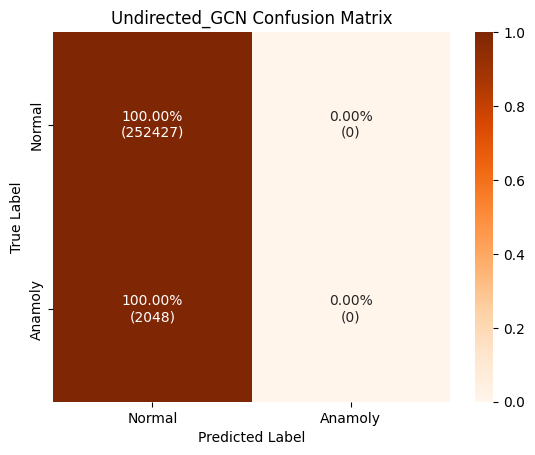



Test 2: How does the model perform on unseen data, of the same error type?: crash_camera_driver1, 1 samples.
Model: Undirected_GCN
              precision    recall  f1-score   support

           0     0.9921    1.0000    0.9961    258517
           1     0.0000    0.0000    0.0000      2048

    accuracy                         0.9921    260565
   macro avg     0.4961    0.5000    0.4980    260565
weighted avg     0.9843    0.9921    0.9882    260565



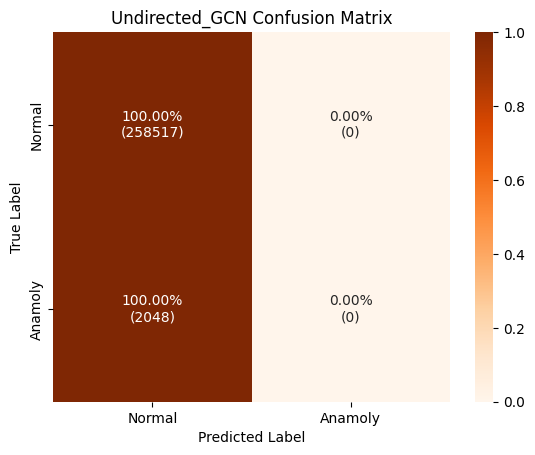



Test 3: How does the model perform on unseen data, of a different error type?: crash_tracker, 1 samples.
Model: Undirected_GCN
              precision    recall  f1-score   support

           0     0.9922    1.0000    0.9961    252023
           1     0.0000    0.0000    0.0000      1988

    accuracy                         0.9922    254011
   macro avg     0.4961    0.5000    0.4980    254011
weighted avg     0.9844    0.9922    0.9883    254011



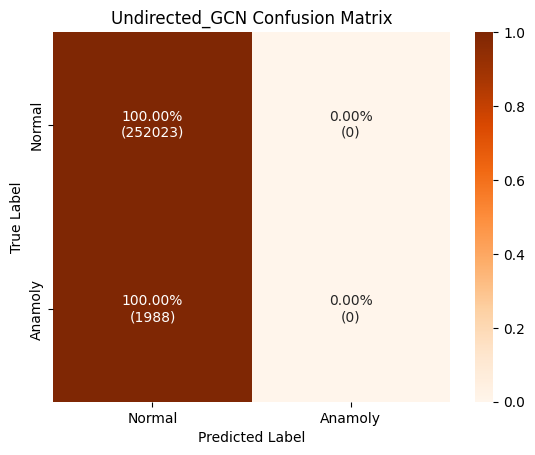



Begin training Directed_GCN. Training data list on a single error type: crash_camera_driver1, 1 samples.
Total number of graphs: 8775, Presence of class 0: 8775, Presence of class 1: 2048
Epoch 1, Total weighted loss: 0.45006, Macro recall: 0.50875, Total accuracy: 0.98625, Macro F1-score: 0.50989. Loss backpropagated 3064 times.
Total number of graphs: 8775, Presence of class 0: 8775, Presence of class 1: 2048
Epoch 2, Total weighted loss: 0.44514, Macro recall: 0.50834, Total accuracy: 0.98687, Macro F1-score: 0.50981. Loss backpropagated 3038 times.
Total number of graphs: 8775, Presence of class 0: 8775, Presence of class 1: 2048
Epoch 3, Total weighted loss: 0.44259, Macro recall: 0.52777, Total accuracy: 0.98122, Macro F1-score: 0.52238. Loss backpropagated 3890 times.
Total number of graphs: 8775, Presence of class 0: 8775, Presence of class 1: 2048
Epoch 4, Total weighted loss: 0.43848, Macro recall: 0.53974, Total accuracy: 0.97999, Macro F1-score: 0.52949. Loss backpropagat

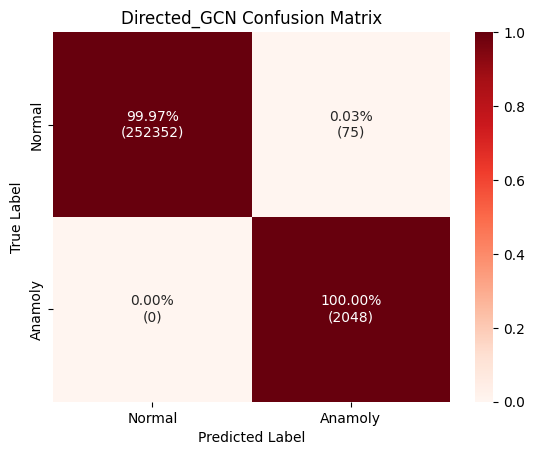



Test 2: How does the model perform on unseen data, of the same error type?: crash_camera_driver1, 1 samples.
Model: Directed_GCN
              precision    recall  f1-score   support

           0     0.9962    1.0000    0.9981    258517
           1     1.0000    0.5161    0.6808      2048

    accuracy                         0.9962    260565
   macro avg     0.9981    0.7581    0.8395    260565
weighted avg     0.9962    0.9962    0.9956    260565



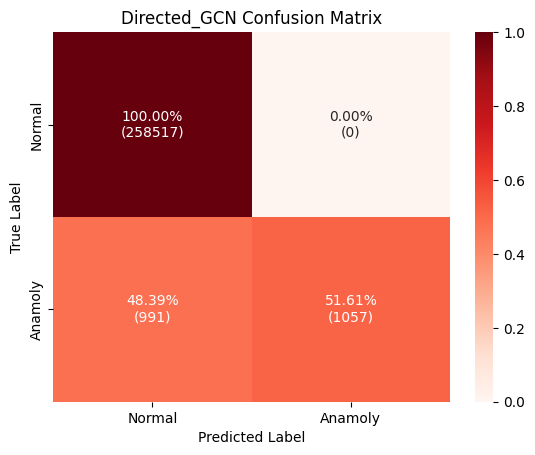



Test 3: How does the model perform on unseen data, of a different error type?: crash_tracker, 1 samples.
Model: Directed_GCN
              precision    recall  f1-score   support

           0     0.9922    1.0000    0.9961    252023
           1     0.0000    0.0000    0.0000      1988

    accuracy                         0.9922    254011
   macro avg     0.4961    0.5000    0.4980    254011
weighted avg     0.9844    0.9922    0.9883    254011



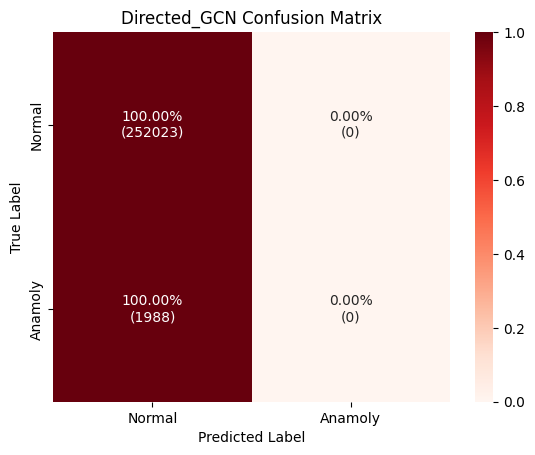

In [ ]:
#GCN

for setting in settings:
  model_name = f'{setting}_GCN'
  model = MODELS['spatial'][model_name]

  print('\n====================\n')
  print(f'Begin training {model_name}. {train_case}.')
  model = MODELS['spatial']['train'](model, train_loader, class_weights=True, num_epoch=20, verbose=True)

  print('\n====================\n')
  print(f'Test 1: Evaluate {model_name} on the training dataset.')
  MODELS['spatial']['evaluate'](model, model_name, train_loader)

  print('\n====================\n')
  print(f'Test 2: {test1}.')
  MODELS['spatial']['evaluate'](model, model_name, test_loader1)

  print('\n====================\n')
  print(f'Test 3: {test2}.')
  MODELS['spatial']['evaluate'](model, model_name, test_loader2)

  optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
  file_name = f'{model_name}_{experiment_session}'
  save_model(model, '', file_name, optimizer)




Begin training Undirected_GraphSAGE. Training data list on a single error type: crash_camera_driver1, 1 samples.
Total number of graphs: 8775, Presence of class 0: 8775, Presence of class 1: 2048
Epoch 1, Total weighted loss: 0.44410, Macro recall: 0.49992, Total accuracy: 0.99180, Macro F1-score: 0.49794. Loss backpropagated 2074 times.
Total number of graphs: 8775, Presence of class 0: 8775, Presence of class 1: 2048
Epoch 2, Total weighted loss: 0.44387, Macro recall: 0.49997, Total accuracy: 0.99189, Macro F1-score: 0.49796. Loss backpropagated 2060 times.
Total number of graphs: 8775, Presence of class 0: 8775, Presence of class 1: 2048
Epoch 3, Total weighted loss: 0.44453, Macro recall: 0.49998, Total accuracy: 0.99192, Macro F1-score: 0.49797. Loss backpropagated 2055 times.
Total number of graphs: 8775, Presence of class 0: 8775, Presence of class 1: 2048
Epoch 4, Total weighted loss: 0.44673, Macro recall: 0.50792, Total accuracy: 0.98364, Macro F1-score: 0.50760. Loss back

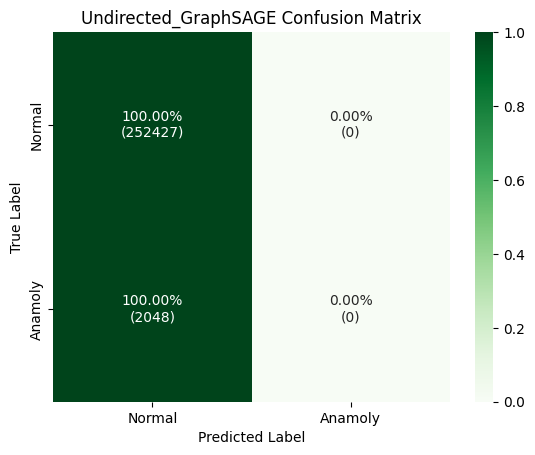



Test 2: How does the model perform on unseen data, of the same error type?: crash_camera_driver1, 1 samples.
Model: Undirected_GraphSAGE
              precision    recall  f1-score   support

           0     0.9921    1.0000    0.9961    258517
           1     0.0000    0.0000    0.0000      2048

    accuracy                         0.9921    260565
   macro avg     0.4961    0.5000    0.4980    260565
weighted avg     0.9843    0.9921    0.9882    260565



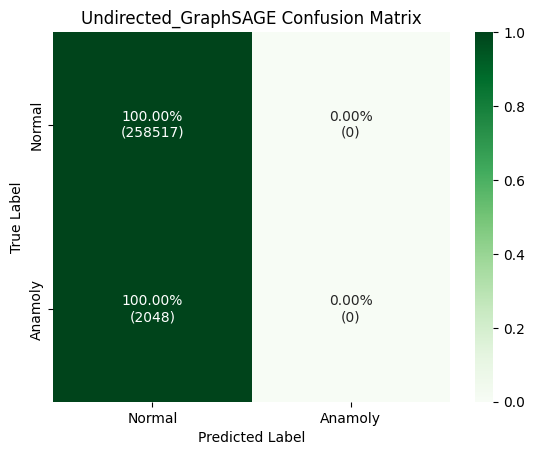



Test 3: How does the model perform on unseen data, of a different error type?: crash_tracker, 1 samples.
Model: Undirected_GraphSAGE
              precision    recall  f1-score   support

           0     0.9922    1.0000    0.9961    252023
           1     0.0000    0.0000    0.0000      1988

    accuracy                         0.9922    254011
   macro avg     0.4961    0.5000    0.4980    254011
weighted avg     0.9844    0.9922    0.9883    254011



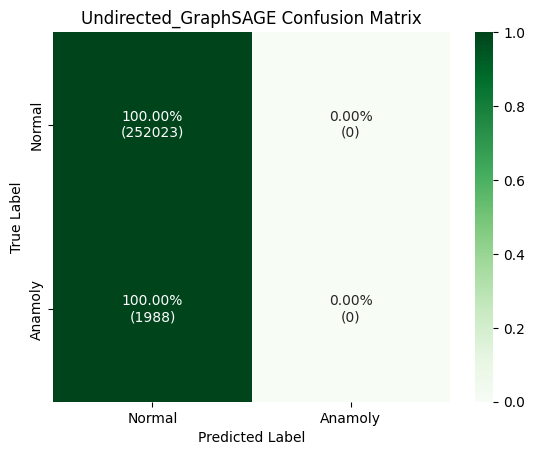



Begin training Directed_GraphSAGE. Training data list on a single error type: crash_camera_driver1, 1 samples.
Total number of graphs: 8775, Presence of class 0: 8775, Presence of class 1: 2048
Epoch 1, Total weighted loss: 0.40968, Macro recall: 0.65750, Total accuracy: 0.99214, Macro F1-score: 0.69499. Loss backpropagated 1743 times.
Total number of graphs: 8775, Presence of class 0: 8775, Presence of class 1: 2048
Epoch 2, Total weighted loss: 0.36875, Macro recall: 0.86457, Total accuracy: 0.99748, Macro F1-score: 0.91094. Loss backpropagated 638 times.
Total number of graphs: 8775, Presence of class 0: 8775, Presence of class 1: 2048
Epoch 3, Total weighted loss: 0.36827, Macro recall: 0.91365, Total accuracy: 0.99827, Macro F1-score: 0.94212. Loss backpropagated 439 times.
Total number of graphs: 8775, Presence of class 0: 8775, Presence of class 1: 2048
Epoch 4, Total weighted loss: 0.36570, Macro recall: 0.90269, Total accuracy: 0.99815, Macro F1-score: 0.93697. Loss backprop

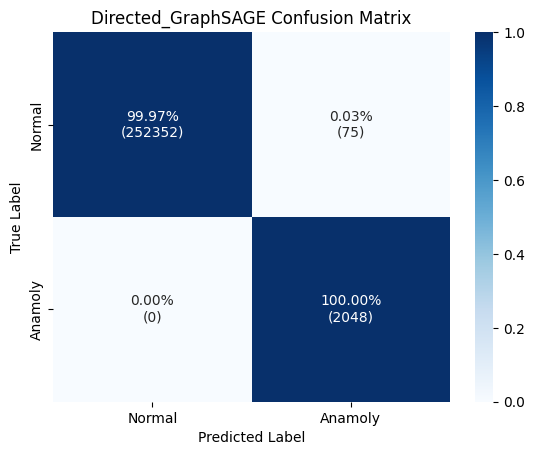



Test 2: How does the model perform on unseen data, of the same error type?: crash_camera_driver1, 1 samples.
Model: Directed_GraphSAGE
              precision    recall  f1-score   support

           0     0.9962    1.0000    0.9981    258517
           1     1.0000    0.5161    0.6808      2048

    accuracy                         0.9962    260565
   macro avg     0.9981    0.7581    0.8395    260565
weighted avg     0.9962    0.9962    0.9956    260565



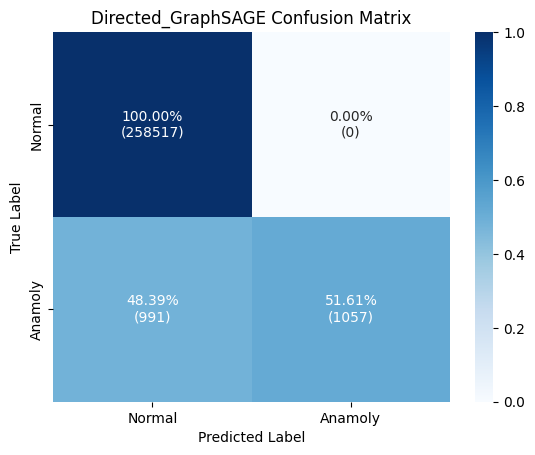



Test 3: How does the model perform on unseen data, of a different error type?: crash_tracker, 1 samples.
Model: Directed_GraphSAGE
              precision    recall  f1-score   support

           0     0.9922    1.0000    0.9961    252023
           1     0.0000    0.0000    0.0000      1988

    accuracy                         0.9922    254011
   macro avg     0.4961    0.5000    0.4980    254011
weighted avg     0.9844    0.9922    0.9883    254011



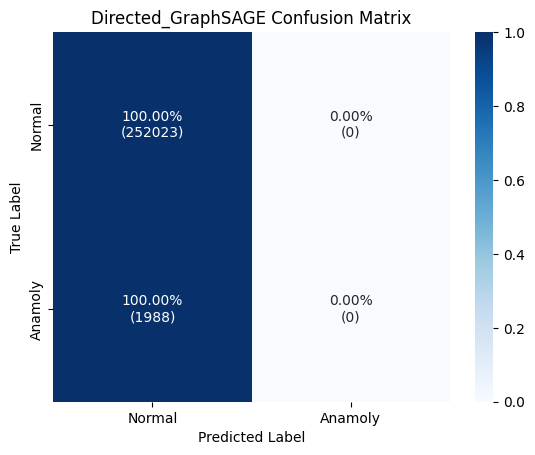

In [ ]:
#SAGE

for setting in settings:
  model_name = f'{setting}_GraphSAGE'
  model = MODELS['spatial'][model_name]

  print('\n====================\n')
  print(f'Begin training {model_name}. {train_case}.')
  model = MODELS['spatial']['train'](model, train_loader, class_weights=True, num_epoch=20, verbose=True)

  print('\n====================\n')
  print(f'Test 1: Evaluate {model_name} on the training dataset.')
  MODELS['spatial']['evaluate'](model, model_name, train_loader)

  print('\n====================\n')
  print(f'Test 2: {test1}.')
  MODELS['spatial']['evaluate'](model, model_name, test_loader1)

  print('\n====================\n')
  print(f'Test 3: {test2}.')
  MODELS['spatial']['evaluate'](model, model_name, test_loader2)

  optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
  file_name = f'{model_name}_{experiment_session}'
  save_model(model, '', file_name, optimizer)



Begin training Undirected_GAT. Training data list on a single error type: crash_camera_driver1, 1 samples.
Total number of graphs: 8775, Presence of class 0: 8775, Presence of class 1: 2048
Epoch 1, Total weighted loss: 0.44979, Macro recall: 0.50015, Total accuracy: 0.99080, Macro F1-score: 0.49897. Loss backpropagated 2194 times.
Total number of graphs: 8775, Presence of class 0: 8775, Presence of class 1: 2048
Epoch 2, Total weighted loss: 0.44344, Macro recall: 0.50000, Total accuracy: 0.99195, Macro F1-score: 0.49798. Loss backpropagated 2048 times.
Total number of graphs: 8775, Presence of class 0: 8775, Presence of class 1: 2048
Epoch 3, Total weighted loss: 0.44377, Macro recall: 0.50000, Total accuracy: 0.99195, Macro F1-score: 0.49798. Loss backpropagated 2049 times.
Total number of graphs: 8775, Presence of class 0: 8775, Presence of class 1: 2048
Epoch 4, Total weighted loss: 0.44471, Macro recall: 0.50000, Total accuracy: 0.99195, Macro F1-score: 0.49798. Loss backpropag

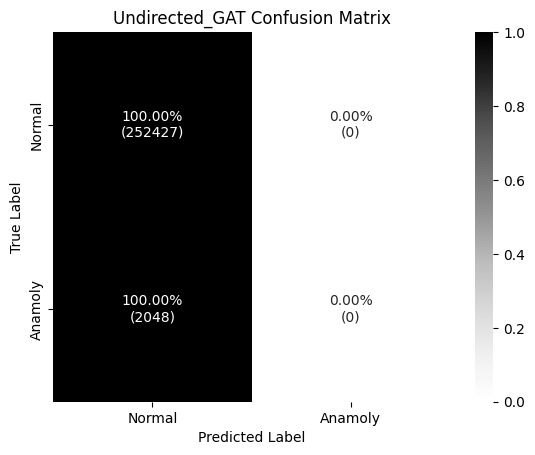



Test 2: How does the model perform on unseen data, of the same error type?: crash_camera_driver1, 1 samples.
Model: Undirected_GAT
              precision    recall  f1-score   support

           0     0.9921    1.0000    0.9961    258517
           1     0.0000    0.0000    0.0000      2048

    accuracy                         0.9921    260565
   macro avg     0.4961    0.5000    0.4980    260565
weighted avg     0.9843    0.9921    0.9882    260565



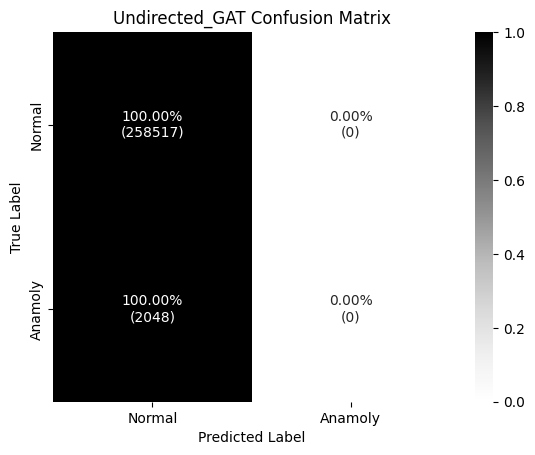



Test 3: How does the model perform on unseen data, of a different error type?: crash_tracker, 1 samples.
Model: Undirected_GAT
              precision    recall  f1-score   support

           0     0.9922    1.0000    0.9961    252023
           1     0.0000    0.0000    0.0000      1988

    accuracy                         0.9922    254011
   macro avg     0.4961    0.5000    0.4980    254011
weighted avg     0.9844    0.9922    0.9883    254011



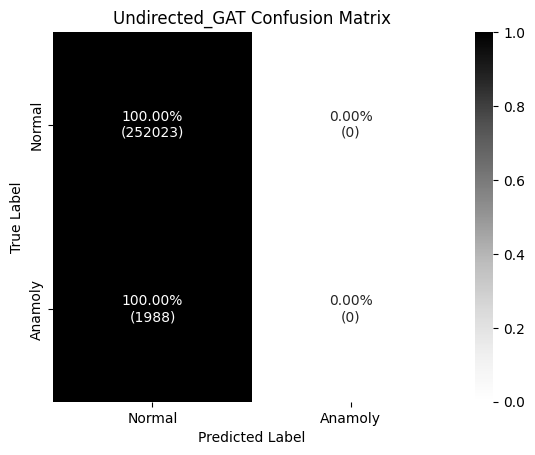



Begin training Directed_GAT. Training data list on a single error type: crash_camera_driver1, 1 samples.
Total number of graphs: 8775, Presence of class 0: 8775, Presence of class 1: 2048
Epoch 1, Total weighted loss: 0.44515, Macro recall: 0.49995, Total accuracy: 0.99186, Macro F1-score: 0.49796. Loss backpropagated 2052 times.
Total number of graphs: 8775, Presence of class 0: 8775, Presence of class 1: 2048
Epoch 2, Total weighted loss: 0.45044, Macro recall: 0.50000, Total accuracy: 0.99195, Macro F1-score: 0.49798. Loss backpropagated 2049 times.
Total number of graphs: 8775, Presence of class 0: 8775, Presence of class 1: 2048
Epoch 3, Total weighted loss: 0.46358, Macro recall: 0.50000, Total accuracy: 0.99195, Macro F1-score: 0.49798. Loss backpropagated 2048 times.
Total number of graphs: 8775, Presence of class 0: 8775, Presence of class 1: 2048
Epoch 4, Total weighted loss: 0.46697, Macro recall: 0.50000, Total accuracy: 0.99195, Macro F1-score: 0.49798. Loss backpropagat

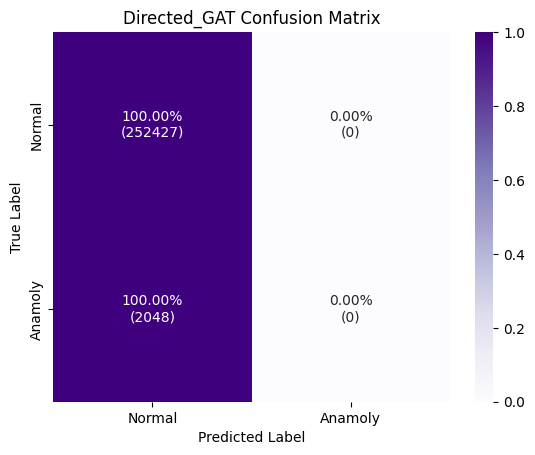



Test 2: How does the model perform on unseen data, of the same error type?: crash_camera_driver1, 1 samples.
Model: Directed_GAT
              precision    recall  f1-score   support

           0     0.9921    1.0000    0.9961    258517
           1     0.0000    0.0000    0.0000      2048

    accuracy                         0.9921    260565
   macro avg     0.4961    0.5000    0.4980    260565
weighted avg     0.9843    0.9921    0.9882    260565



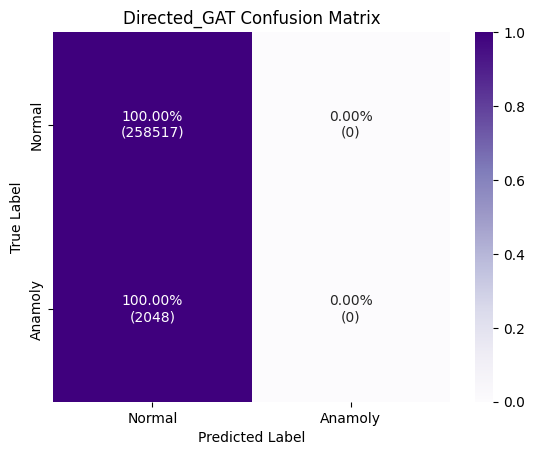



Test 3: How does the model perform on unseen data, of a different error type?: crash_tracker, 1 samples.
Model: Directed_GAT
              precision    recall  f1-score   support

           0     0.9922    1.0000    0.9961    252023
           1     0.0000    0.0000    0.0000      1988

    accuracy                         0.9922    254011
   macro avg     0.4961    0.5000    0.4980    254011
weighted avg     0.9844    0.9922    0.9883    254011



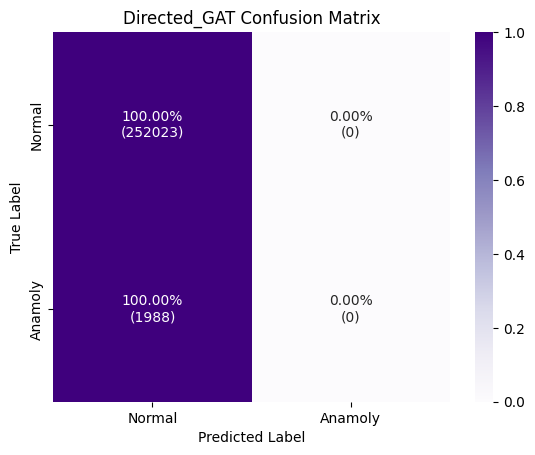

In [ ]:
#GAT

for setting in settings:
  model_name = f'{setting}_GAT'
  model = MODELS['spatial'][model_name]

  print('\n====================\n')
  print(f'Begin training {model_name}. {train_case}.')
  model = MODELS['spatial']['train'](model, train_loader, class_weights=True, num_epoch=20, verbose=True)

  print('\n====================\n')
  print(f'Test 1: Evaluate {model_name} on the training dataset.')
  MODELS['spatial']['evaluate'](model, model_name, train_loader)

  print('\n====================\n')
  print(f'Test 2: {test1}.')
  MODELS['spatial']['evaluate'](model, model_name, test_loader1)

  print('\n====================\n')
  print(f'Test 3: {test2}.')
  MODELS['spatial']['evaluate'](model, model_name, test_loader2)

  optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
  file_name = f'{model_name}_{experiment_session}'
  save_model(model, '', file_name, optimizer)

### Spatiotemporal model experiments: Undirected vs. Directed

In [ ]:
train_case = 'Training data list on a single error type: crash_camera_driver1, 1 samples'
train_loader = spatiotemporal_data_loader(experiment_datalists[0]['Training data list on a single error type: crash_camera_driver1, 1 samples'])

/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [ ]:
test1 = 'How does the model perform on unseen data, of the same error type?: crash_camera_driver1, 1 samples'
test2 = 'How does the model perform on unseen data, of a different error type?: crash_tracker, 1 samples'

test_loader1 = spatiotemporal_data_loader(experiment_datalists[0][test1])
test_loader2 = spatiotemporal_data_loader(experiment_datalists[0][test2])



Begin training Undirected_GRUGCN. Training data list on a single error type: crash_camera_driver1, 1 samples.
Total number of graphs: 8775, Presence of class 0: 8775, Presence of class 1: 2048
Epoch 1, Total weighted loss: 0.55677, Macro recall: 0.94473, Total accuracy: 0.97731, Macro F1-score: 0.69058. Loss backpropagated 2046 times.
Total number of graphs: 8775, Presence of class 0: 8775, Presence of class 1: 2048
Epoch 2, Total weighted loss: 0.34515, Macro recall: 0.94530, Total accuracy: 0.97651, Macro F1-score: 0.68652. Loss backpropagated 2048 times.
Total number of graphs: 8775, Presence of class 0: 8775, Presence of class 1: 2048
Epoch 3, Total weighted loss: 0.34013, Macro recall: 0.96614, Total accuracy: 0.97655, Macro F1-score: 0.69206. Loss backpropagated 2049 times.
Total number of graphs: 8775, Presence of class 0: 8775, Presence of class 1: 2048
Epoch 4, Total weighted loss: 0.33885, Macro recall: 0.97330, Total accuracy: 0.97634, Macro F1-score: 0.69277. Loss backpro

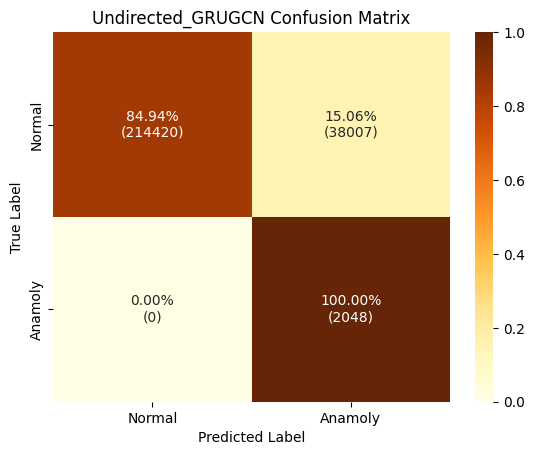



Test 2: How does the model perform on unseen data, of the same error type?: crash_camera_driver1, 1 samples.
Model: Undirected_GRUGCN
              precision    recall  f1-score   support

           0     1.0000    0.8497    0.9188    258517
           1     0.0501    1.0000    0.0954      2048

    accuracy                         0.8509    260565
   macro avg     0.5250    0.9249    0.5071    260565
weighted avg     0.9925    0.8509    0.9123    260565



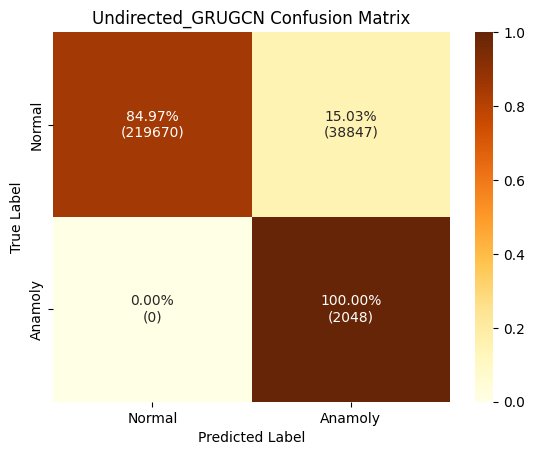



Test 3: How does the model perform on unseen data, of a different error type?: crash_tracker, 1 samples.
Model: Undirected_GRUGCN
              precision    recall  f1-score   support

           0     1.0000    0.8492    0.9185    252023
           1     0.0497    1.0000    0.0947      1988

    accuracy                         0.8504    254011
   macro avg     0.5249    0.9246    0.5066    254011
weighted avg     0.9926    0.8504    0.9120    254011



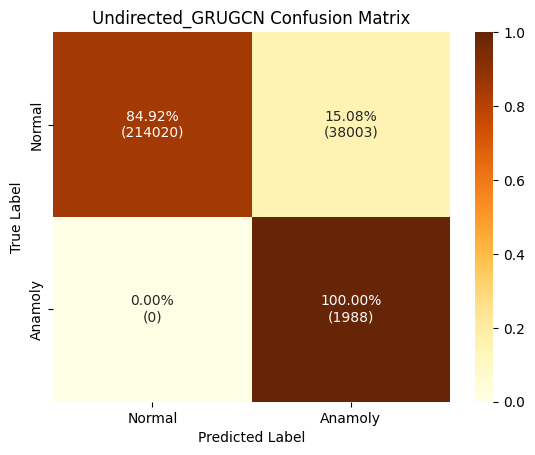



Begin training Directed_GRUGCN. Training data list on a single error type: crash_camera_driver1, 1 samples.
Total number of graphs: 8775, Presence of class 0: 8775, Presence of class 1: 2048
Epoch 1, Total weighted loss: 0.58924, Macro recall: 0.92886, Total accuracy: 0.99194, Macro F1-score: 0.81467. Loss backpropagated 576 times.
Total number of graphs: 8775, Presence of class 0: 8775, Presence of class 1: 2048
Epoch 2, Total weighted loss: 0.34198, Macro recall: 0.94344, Total accuracy: 0.98724, Macro F1-score: 0.76242. Loss backpropagated 1589 times.
Total number of graphs: 8775, Presence of class 0: 8775, Presence of class 1: 2048
Epoch 3, Total weighted loss: 0.35185, Macro recall: 0.88755, Total accuracy: 0.98830, Macro F1-score: 0.75664. Loss backpropagated 1255 times.
Recall score not improving. Early stopping triggered.


Test 1: Evaluate Directed_GRUGCN on the training dataset.
Model: Directed_GRUGCN
              precision    recall  f1-score   support

           0     1

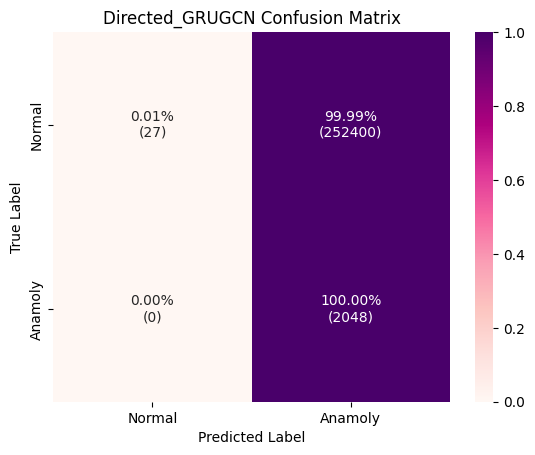



Test 2: How does the model perform on unseen data, of the same error type?: crash_camera_driver1, 1 samples.
Model: Directed_GRUGCN
              precision    recall  f1-score   support

           0     1.0000    0.0001    0.0002    258517
           1     0.0079    1.0000    0.0156      2048

    accuracy                         0.0080    260565
   macro avg     0.5039    0.5001    0.0079    260565
weighted avg     0.9922    0.0080    0.0003    260565



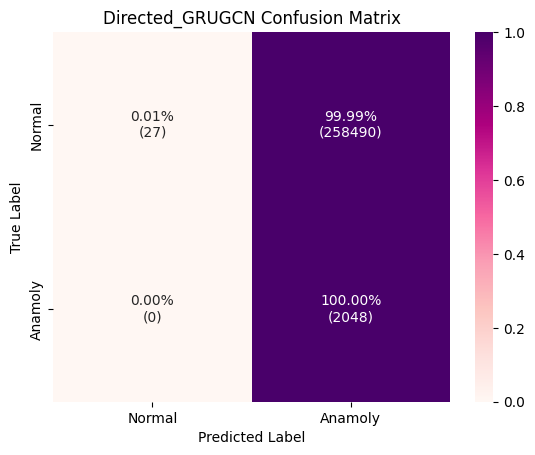



Test 3: How does the model perform on unseen data, of a different error type?: crash_tracker, 1 samples.
Model: Directed_GRUGCN
              precision    recall  f1-score   support

           0     1.0000    0.0001    0.0002    252023
           1     0.0078    1.0000    0.0155      1988

    accuracy                         0.0079    254011
   macro avg     0.5039    0.5001    0.0079    254011
weighted avg     0.9922    0.0079    0.0003    254011



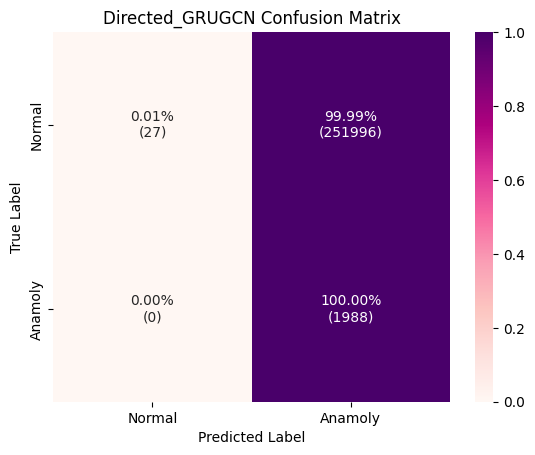

In [ ]:
#GRUGCN

for setting in settings:
  model_name = f'{setting}_GRUGCN'
  model = MODELS['spatiotemporal'][model_name]

  print('\n====================\n')
  print(f'Begin training {model_name}. {train_case}.')
  model = MODELS['spatiotemporal']['train'](model, train_loader, class_weights=True, num_epoch=20, verbose=True)

  print('\n====================\n')
  print(f'Test 1: Evaluate {model_name} on the training dataset.')
  MODELS['spatiotemporal']['evaluate'](model, model_name, train_loader)

  print('\n====================\n')
  print(f'Test 2: {test1}.')
  MODELS['spatiotemporal']['evaluate'](model, model_name, test_loader1)

  print('\n====================\n')
  print(f'Test 3: {test2}.')
  MODELS['spatiotemporal']['evaluate'](model, model_name, test_loader2)

  optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
  file_name = model_name
  save_model(model, '', file_name, optimizer)



Begin training Undirected_GRUSAGE. Training data list on a single error type: crash_camera_driver1, 1 samples.
Total number of graphs: 8775, Presence of class 0: 8775, Presence of class 1: 2048
Epoch 1, Total weighted loss: 0.58779, Macro recall: 0.95690, Total accuracy: 0.97166, Macro F1-score: 0.66700. Loss backpropagated 2051 times.
Total number of graphs: 8775, Presence of class 0: 8775, Presence of class 1: 2048
Epoch 2, Total weighted loss: 0.34083, Macro recall: 0.96402, Total accuracy: 0.97619, Macro F1-score: 0.68967. Loss backpropagated 2049 times.
Total number of graphs: 8775, Presence of class 0: 8775, Presence of class 1: 2048
Epoch 3, Total weighted loss: 0.33874, Macro recall: 0.97392, Total accuracy: 0.97612, Macro F1-score: 0.69176. Loss backpropagated 2049 times.
Total number of graphs: 8775, Presence of class 0: 8775, Presence of class 1: 2048
Epoch 4, Total weighted loss: 0.33792, Macro recall: 0.97753, Total accuracy: 0.97608, Macro F1-score: 0.69249. Loss backpr

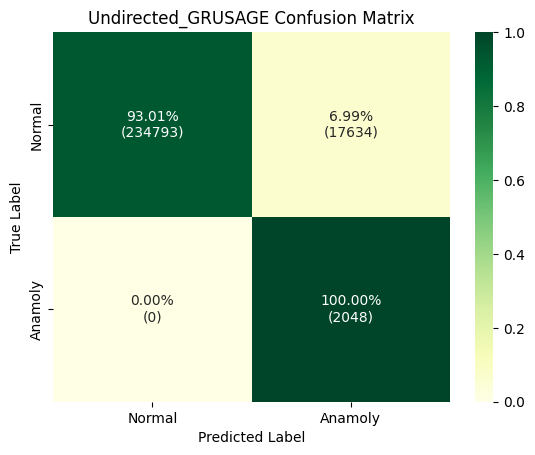



Test 2: How does the model perform on unseen data, of the same error type?: crash_camera_driver1, 1 samples.
Model: Undirected_GRUSAGE
              precision    recall  f1-score   support

           0     1.0000    0.9285    0.9629    258517
           1     0.0998    1.0000    0.1815      2048

    accuracy                         0.9291    260565
   macro avg     0.5499    0.9643    0.5722    260565
weighted avg     0.9929    0.9291    0.9568    260565



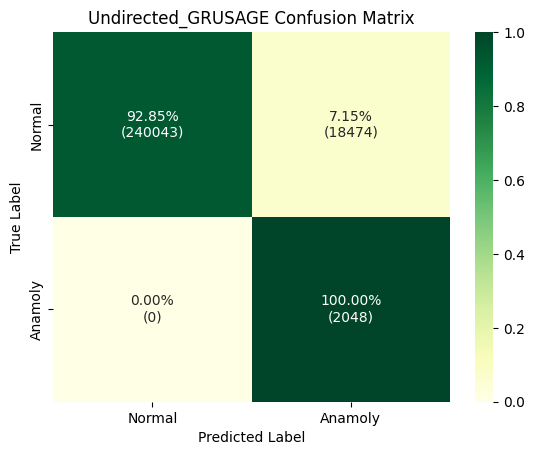



Test 3: How does the model perform on unseen data, of a different error type?: crash_tracker, 1 samples.
Model: Undirected_GRUSAGE
              precision    recall  f1-score   support

           0     1.0000    0.9300    0.9638    252023
           1     0.1013    1.0000    0.1840      1988

    accuracy                         0.9306    254011
   macro avg     0.5507    0.9650    0.5739    254011
weighted avg     0.9930    0.9306    0.9577    254011



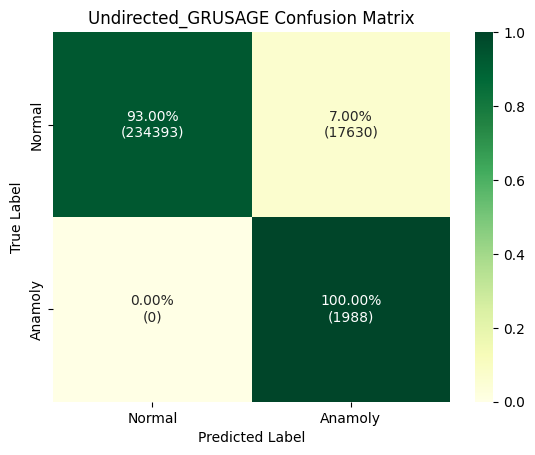



Begin training Directed_GRUSAGE. Training data list on a single error type: crash_camera_driver1, 1 samples.
Total number of graphs: 8775, Presence of class 0: 8775, Presence of class 1: 2048
Epoch 1, Total weighted loss: 0.55313, Macro recall: 0.97059, Total accuracy: 0.99931, Macro F1-score: 0.97800. Loss backpropagated 149 times.
Total number of graphs: 8775, Presence of class 0: 8775, Presence of class 1: 2048
Epoch 2, Total weighted loss: 0.33609, Macro recall: 0.98172, Total accuracy: 0.99881, Macro F1-score: 0.96397. Loss backpropagated 123 times.
Total number of graphs: 8775, Presence of class 0: 8775, Presence of class 1: 2048
Epoch 3, Total weighted loss: 0.34240, Macro recall: 0.99075, Total accuracy: 0.99703, Macro F1-score: 0.92030. Loss backpropagated 247 times.
Total number of graphs: 8775, Presence of class 0: 8775, Presence of class 1: 2048
Epoch 4, Total weighted loss: 0.32250, Macro recall: 0.98785, Total accuracy: 0.99943, Macro F1-score: 0.98236. Loss backpropaga

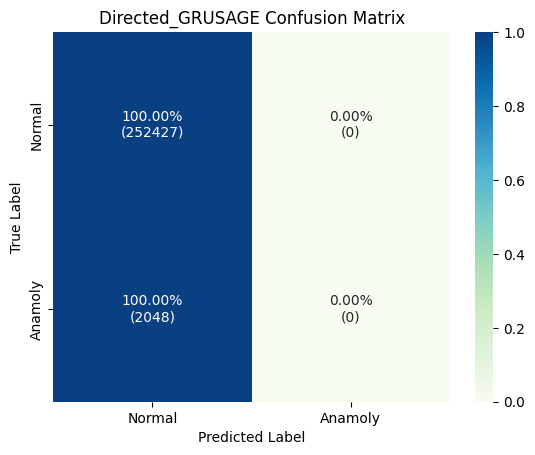



Test 2: How does the model perform on unseen data, of the same error type?: crash_camera_driver1, 1 samples.
Model: Directed_GRUSAGE
              precision    recall  f1-score   support

           0     0.9921    1.0000    0.9961    258517
           1     0.0000    0.0000    0.0000      2048

    accuracy                         0.9921    260565
   macro avg     0.4961    0.5000    0.4980    260565
weighted avg     0.9843    0.9921    0.9882    260565



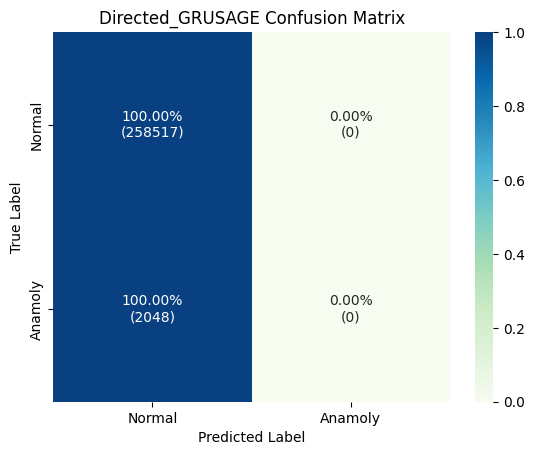



Test 3: How does the model perform on unseen data, of a different error type?: crash_tracker, 1 samples.
Model: Directed_GRUSAGE
              precision    recall  f1-score   support

           0     0.9922    1.0000    0.9961    252023
           1     0.0000    0.0000    0.0000      1988

    accuracy                         0.9922    254011
   macro avg     0.4961    0.5000    0.4980    254011
weighted avg     0.9844    0.9922    0.9883    254011



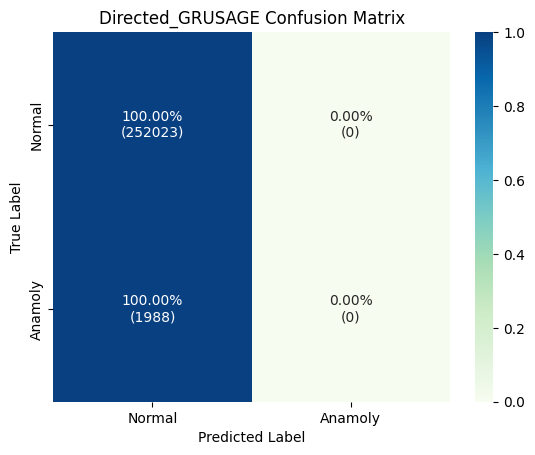

In [ ]:
#GRUSAGE

for setting in settings:
  model_name = f'{setting}_GRUSAGE'
  model = MODELS['spatiotemporal'][model_name]

  print('\n====================\n')
  print(f'Begin training {model_name}. {train_case}.')
  model = MODELS['spatiotemporal']['train'](model, train_loader, class_weights=True, num_epoch=20, verbose=True)

  print('\n====================\n')
  print(f'Test 1: Evaluate {model_name} on the training dataset.')
  MODELS['spatiotemporal']['evaluate'](model, model_name, train_loader)

  print('\n====================\n')
  print(f'Test 2: {test1}.')
  MODELS['spatiotemporal']['evaluate'](model, model_name, test_loader1)

  print('\n====================\n')
  print(f'Test 3: {test2}.')
  MODELS['spatiotemporal']['evaluate'](model, model_name, test_loader2)

  optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
  file_name = model_name
  save_model(model, '', file_name, optimizer)



Begin training Undirected_GRUGAT. Training data list on a single error type: crash_camera_driver1, 1 samples.
Total number of graphs: 8775, Presence of class 0: 8775, Presence of class 1: 2048
Epoch 1, Total weighted loss: 0.57596, Macro recall: 0.96720, Total accuracy: 0.97624, Macro F1-score: 0.69071. Loss backpropagated 2053 times.
Total number of graphs: 8775, Presence of class 0: 8775, Presence of class 1: 2048
Epoch 2, Total weighted loss: 0.34485, Macro recall: 0.94733, Total accuracy: 0.97717, Macro F1-score: 0.69052. Loss backpropagated 2050 times.
Total number of graphs: 8775, Presence of class 0: 8775, Presence of class 1: 2048
Epoch 3, Total weighted loss: 0.34964, Macro recall: 0.92730, Total accuracy: 0.97781, Macro F1-score: 0.68859. Loss backpropagated 2050 times.
Recall score not improving. Early stopping triggered.


Test 1: Evaluate Undirected_GRUGAT on the training dataset.
Model: Undirected_GRUGAT
              precision    recall  f1-score   support

           

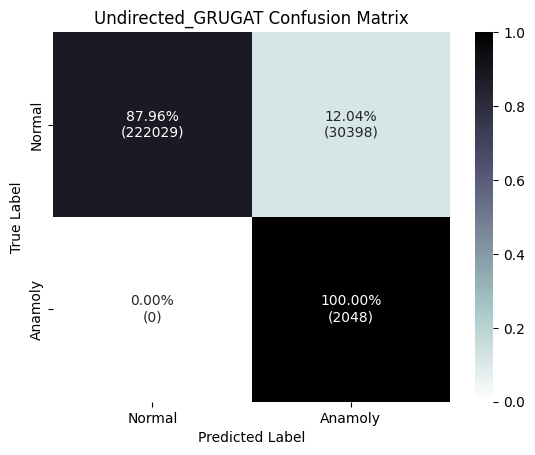



Test 2: How does the model perform on unseen data, of the same error type?: crash_camera_driver1, 1 samples.
Model: Undirected_GRUGAT
              precision    recall  f1-score   support

           0     1.0000    0.8792    0.9357    258517
           1     0.0615    1.0000    0.1159      2048

    accuracy                         0.8801    260565
   macro avg     0.5308    0.9396    0.5258    260565
weighted avg     0.9926    0.8801    0.9293    260565



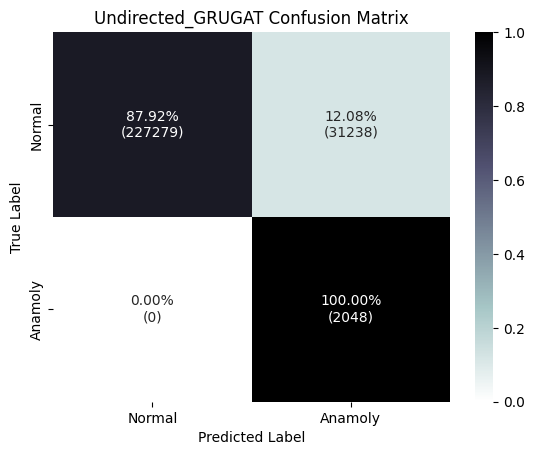



Test 3: How does the model perform on unseen data, of a different error type?: crash_tracker, 1 samples.
Model: Undirected_GRUGAT
              precision    recall  f1-score   support

           0     1.0000    0.8794    0.9358    252023
           1     0.0614    1.0000    0.1157      1988

    accuracy                         0.8803    254011
   macro avg     0.5307    0.9397    0.5258    254011
weighted avg     0.9927    0.8803    0.9294    254011



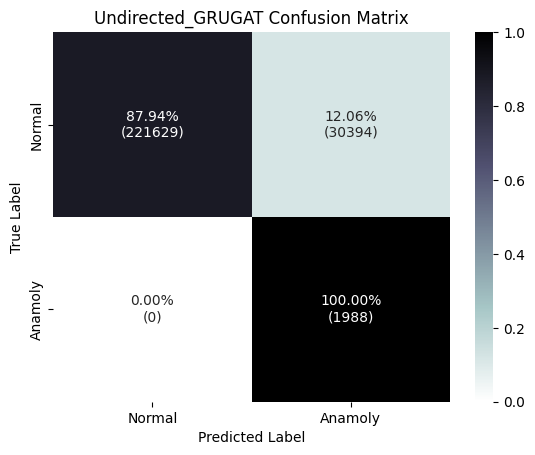



Begin training Directed_GRUGAT. Training data list on a single error type: crash_camera_driver1, 1 samples.
Total number of graphs: 8775, Presence of class 0: 8775, Presence of class 1: 2048
Epoch 1, Total weighted loss: 0.62288, Macro recall: 0.98073, Total accuracy: 0.99925, Macro F1-score: 0.97669. Loss backpropagated 86 times.
Total number of graphs: 8775, Presence of class 0: 8775, Presence of class 1: 2048
Epoch 2, Total weighted loss: 0.43312, Macro recall: 0.99775, Total accuracy: 0.99986, Macro F1-score: 0.99559. Loss backpropagated 36 times.
Total number of graphs: 8775, Presence of class 0: 8775, Presence of class 1: 2048
Epoch 3, Total weighted loss: 0.36475, Macro recall: 0.99852, Total accuracy: 0.99994, Macro F1-score: 0.99828. Loss backpropagated 14 times.
Total number of graphs: 8775, Presence of class 0: 8775, Presence of class 1: 2048
Epoch 4, Total weighted loss: 0.36129, Macro recall: 0.99898, Total accuracy: 0.99990, Macro F1-score: 0.99681. Loss backpropagated 

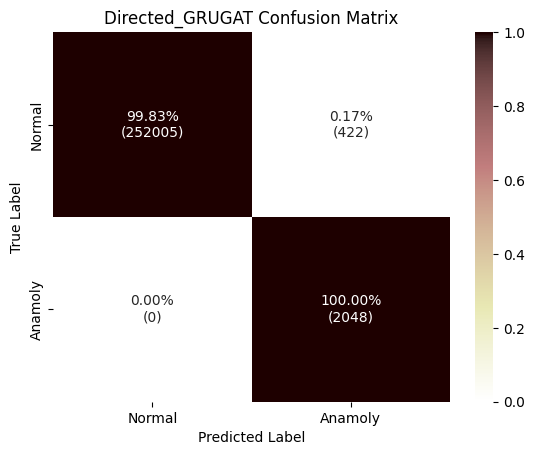



Test 2: How does the model perform on unseen data, of the same error type?: crash_camera_driver1, 1 samples.
Model: Directed_GRUGAT
              precision    recall  f1-score   support

           0     0.9977    1.0000    0.9989    258517
           1     1.0000    0.7100    0.8304      2048

    accuracy                         0.9977    260565
   macro avg     0.9989    0.8550    0.9146    260565
weighted avg     0.9977    0.9977    0.9975    260565



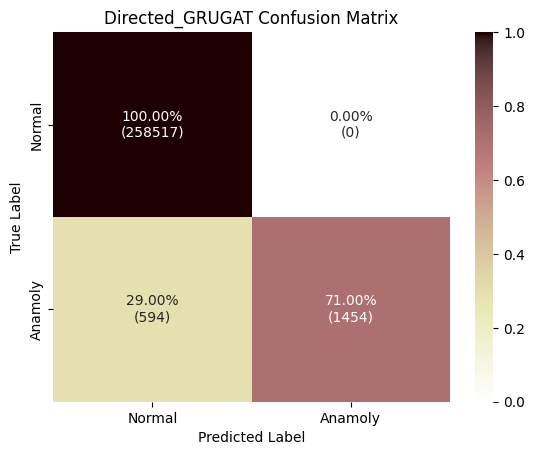



Test 3: How does the model perform on unseen data, of a different error type?: crash_tracker, 1 samples.
Model: Directed_GRUGAT
              precision    recall  f1-score   support

           0     0.9922    1.0000    0.9961    252023
           1     0.0000    0.0000    0.0000      1988

    accuracy                         0.9922    254011
   macro avg     0.4961    0.5000    0.4980    254011
weighted avg     0.9844    0.9922    0.9883    254011



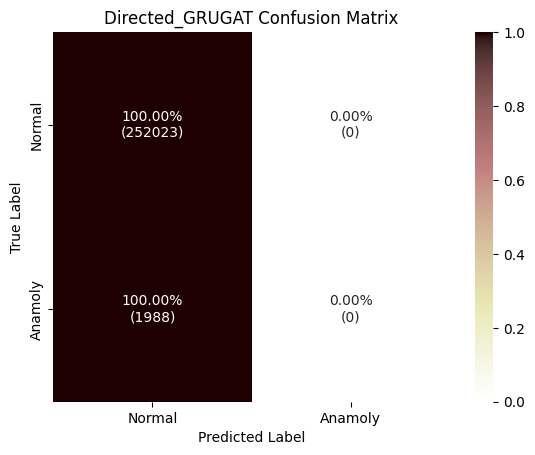

In [ ]:
#GRUGAT

for setting in settings:
  model_name = f'{setting}_GRUGAT'
  model = MODELS['spatiotemporal'][model_name]

  print('\n====================\n')
  print(f'Begin training {model_name}. {train_case}.')
  model = MODELS['spatiotemporal']['train'](model, train_loader, class_weights=True, num_epoch=20, verbose=True)

  print('\n====================\n')
  print(f'Test 1: Evaluate {model_name} on the training dataset.')
  MODELS['spatiotemporal']['evaluate'](model, model_name, train_loader)

  print('\n====================\n')
  print(f'Test 2: {test1}.')
  MODELS['spatiotemporal']['evaluate'](model, model_name, test_loader1)

  print('\n====================\n')
  print(f'Test 3: {test2}.')
  MODELS['spatiotemporal']['evaluate'](model, model_name, test_loader2)

  optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
  file_name = model_name
  save_model(model, '', file_name, optimizer)

## Download models

In [ ]:
from google.colab import files

In [ ]:
save_path = '/content/drive/MyDrive/CS224 Project'

In [ ]:
os.makedirs(os.path.join(save_path, 'Model experiments', experiment_session), exist_ok=True)

In [ ]:
type(list(MODELS['spatial'].values())[0])

__main__.spatialGCN

In [ ]:
MODELS

{'spatial': {'Undirected_GCN': spatialGCN(
    (conv1): GCNConv(9, 18)
    (conv2): GCNConv(18, 18)
    (dropout): Dropout(p=0.5, inplace=False)
    (classifier): Linear(in_features=18, out_features=2, bias=True)
  ),
  'Undirected_GraphSAGE': spatialGraphSAGE(
    (conv1): SAGEConv(9, 18, aggr=mean)
    (conv2): SAGEConv(18, 18, aggr=mean)
    (dropout): Dropout(p=0.5, inplace=False)
    (classifier): Linear(in_features=18, out_features=2, bias=True)
  ),
  'Undirected_GAT': spatialGAT(
    (conv1): GATConv(9, 18, heads=18)
    (conv2): GATConv(324, 18, heads=1)
    (dropout): Dropout(p=0.5, inplace=False)
    (classifier): Linear(in_features=18, out_features=2, bias=True)
  ),
  'Directed_GCN': spatialGCN(
    (conv1): DirectedGCNConv(
      (0-1): 2 x GCNConv(9, 18)
      (2): Linear(in_features=9, out_features=18, bias=True)
    )
    (conv2): DirectedGCNConv(
      (0-1): 2 x GCNConv(18, 18)
      (2): Linear(in_features=18, out_features=18, bias=True)
    )
    (dropout): Dropout

In [ ]:
for mode in modes:
  for model_name in MODELS[mode].keys():
    model = MODELS[mode][model_name]
    torch.save(model, f'{save_path}/Model experiments/{experiment_session}/{model_name}_{experiment_session}.pth')
    print(f'{model_name} saved')

Undirected_GCN saved
Undirected_GraphSAGE saved
Undirected_GAT saved
Directed_GCN saved
Directed_GraphSAGE saved
Directed_GAT saved
load saved
train saved
evaluate saved
Undirected_GRUGCN saved
Undirected_GRUSAGE saved
Undirected_GRUGAT saved
Directed_GRUGCN saved
Directed_GRUSAGE saved
Directed_GRUGAT saved
load saved
train saved
evaluate saved


###Load model example

In [ ]:
exp = torch.load(f'{save_path}/Model experiments/{experiment_session}/Directed_GRUSAGE_{experiment_session}.pth', weights_only=False)
exp.eval()

GRUSAGE(
  (conv1): DirectedSAGEConv(
    (src_to_dst_conv): SAGEConv(9, 18, aggr=mean)
    (dst_to_src_conv): SAGEConv(9, 18, aggr=mean)
    (lin_self): Linear(in_features=9, out_features=18, bias=True)
  )
  (conv2): DirectedSAGEConv(
    (src_to_dst_conv): SAGEConv(18, 18, aggr=mean)
    (dst_to_src_conv): SAGEConv(18, 18, aggr=mean)
    (lin_self): Linear(in_features=18, out_features=18, bias=True)
  )
  (gru): GRU(18, 18)
  (dropout): Dropout(p=0.5, inplace=False)
  (classifier): Linear(in_features=18, out_features=2, bias=True)
)